In [ ]:
from cil.io import NEXUSDataReader, NEXUSDataWriter
from cil.optimisation.algorithms import SIRT
from cil.plugins.astra.operators import ProjectionOperator
from cil.optimisation.functions import IndicatorBox
from cil.utilities.display import show2D
from cil.processors import Slicer

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

import numpy as np
import h5py

## Load data after the `RingRemover` processor. 

## For the reconstruction, we use only 5 channels and 5 vertical slices.

## To match the results in the publication comment the line below.

In [2]:
name = "data_after_ring_remover_318_398.nxs"
reader = NEXUSDataReader(file_name="HyperspectralData/"+name)
data = reader.read()

# Comment to use all the channels and vertical slices
data = Slicer(roi={'channel': (37,42),'vertical': (17,22)})(data)

# Get image, acquisition geometries

In [3]:
ag3D = data.geometry.subset(channel=0)
ig3D = ag3D.get_ImageGeometry()

A = ProjectionOperator(ig3D, ag3D,'gpu')

ig = data.geometry.get_ImageGeometry()

# Non-negativity constraint

In [4]:
constraint = IndicatorBox(lower=0.0)

In [5]:
max_iterations = 100 

# SIRT reconstruction without warm start

In [6]:
sirt4D_nowarm = ig.allocate()

x0 = ig3D.allocate()

constraint = IndicatorBox(lower=0)
sirt3D_nowarm = SIRT(max_iteration = max_iterations)

for i in range(ig.channels):
    sirt3D_nowarm.iteration=0
    sirt3D_nowarm.set_up(initial=x0, operator=A, constraint=constraint, 
                     data=data.subset(channel=i))  
    sirt3D_nowarm.run(verbose=0)
    sirt4D_nowarm.fill(sirt3D_nowarm.solution, channel=i)  
    print("Finish SIRT reconstruction for channel {}".format(i))

SIRT setting up
SIRT configured
        0        100         0.000                     
Finish SIRT reconstruction for channel 0
SIRT setting up
SIRT configured
        0        100         0.050          3.73922e+03
Finish SIRT reconstruction for channel 1
SIRT setting up
SIRT configured
        0        100         0.067          3.94333e+03
Finish SIRT reconstruction for channel 2
SIRT setting up
SIRT configured
        0        100         0.076          4.91539e+03
Finish SIRT reconstruction for channel 3
SIRT setting up
SIRT configured
        0        100         0.072          4.05572e+03
Finish SIRT reconstruction for channel 4


# SIRT reconstruction with warm start. 

## Initialise with respect to the SIRT reconstruction of the previous channel

In [7]:
sirt4D_warm = ig.allocate()
x0 = ig3D.allocate()
constraint = IndicatorBox(lower=0)
sirt3D_warm = SIRT(max_iteration = max_iterations)


for i in range(ig.channels):
    sirt3D_warm.iteration=0
    sirt3D_warm.set_up(initial=x0, operator=A, constraint=constraint, 
                     data=data.subset(channel=i))  
    sirt3D_warm.run(verbose=0)
    sirt4D_warm.fill(sirt3D_warm.solution, channel=i)
    x0.fill(sirt3D_warm.solution)
    print("Finish SIRT reconstruction for channel {}".format(i))

SIRT setting up
SIRT configured
        0        100         0.000                     
Finish SIRT reconstruction for channel 0
SIRT setting up
SIRT configured
        0        100         0.095          3.73922e+03
Finish SIRT reconstruction for channel 1
SIRT setting up
SIRT configured
        0        100         0.086          3.88448e+03
Finish SIRT reconstruction for channel 2
SIRT setting up
SIRT configured
        0        100         0.087          5.03485e+03
Finish SIRT reconstruction for channel 3
SIRT setting up
SIRT configured
        0        100         0.083          4.21651e+03
Finish SIRT reconstruction for channel 4


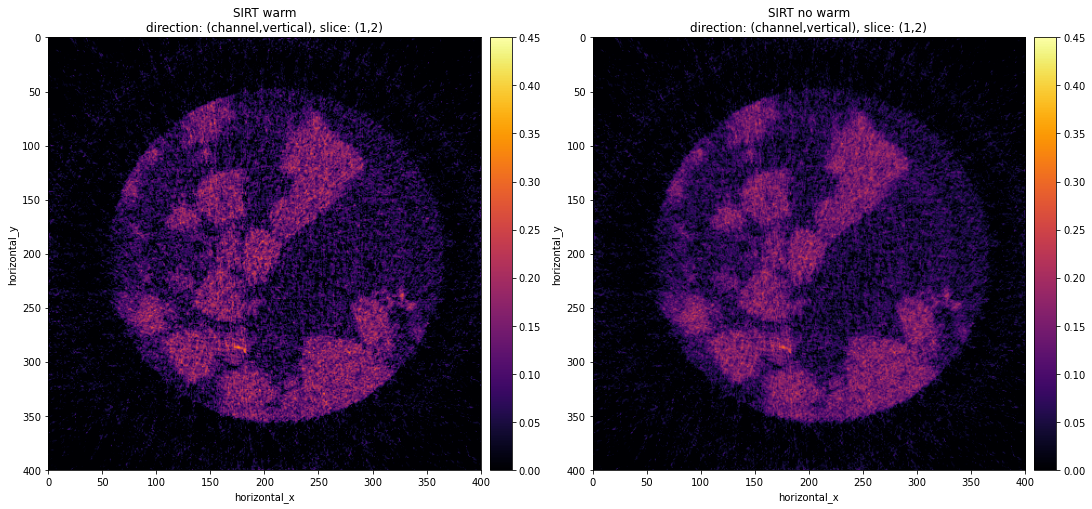

In [18]:
show2D([sirt4D_warm, sirt4D_nowarm], slice_list=[1,1],
       title=["SIRT warm","SIRT no warm"], 
       origin="upper", fix_range=(0, 0.45), cmap="inferno")

In [19]:
# Save SIRT reconstrucitions
name = "sirt_recon_nowarm.nxs"
writer = NEXUSDataWriter(file_name = "HyperspectralData/" + name,
                     data = sirt4D_nowarm)
writer.write()

name = "sirt_recon_warm.nxs"
writer = NEXUSDataWriter(file_name = "HyperspectralData/" + name,
                     data = sirt4D_warm)
writer.write()